<center><h1>𝓢𝓮𝓷𝓽𝓲𝓶𝓮𝓷𝓽 𝓪𝓷𝓪𝓷𝓵𝔂𝓼𝓲𝓼</h1></center>


<center><img src="https://hsto.org/webt/t6/sr/jr/t6srjrmjjmm6qn8gpld9emy4txu.gif" width="400"/></center>

For this task we are going to use the `Amazon Kindle Book Review for Sentiment Analysis` Dataset. Let's understand the dataset! 

You can download the dataset [**here!**](https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis)

<center>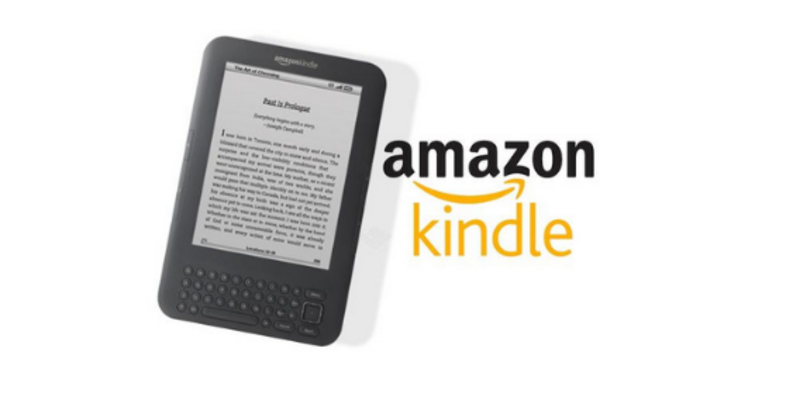</center>

This is a small subset of dataset of Book reviews from Amazon Kindle Store category.

### columns: 
- asin - ID of the product, like B000FA64PK
- helpful - helpfulness rating of the review - example: 2/3.
- overall - rating of the product.
- reviewText - text of the review (heading).
- reviewTime - time of the review (raw).
- reviewerID - ID of the reviewer, like A3SPTOKDG7WBLN
- reviewerName - name of the reviewer.
- summary - summary of the review (description).
- unixReviewTime - unix timestamp.


Let's start~

In [1]:
# imports 
import warnings 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import re
import json 
import nltk
import spacy
import string
import unicodedata
from bs4 import BeautifulSoup
from textblob import TextBlob 
from nltk.stem import WordNetLemmatizer

from IPython import display 
display.set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [2]:
# load the data 
data = pd.read_csv("../input/amazon-kindle-book-review-for-sentiment-analysis/all_kindle_review .csv")
data.head()

,Unnamed: 0,Unnamed: 0.1,asin,helpful,rating,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,11539,B0033UV8HI,"[8, 10]",3,"Jace Rankin may be short, but he's nothing to ...","09 2, 2010",A3HHXRELK8BHQG,Ridley,Entertaining But Average,1283385600
1,1,5957,B002HJV4DE,"[1, 1]",5,Great short read. I didn't want to put it dow...,"10 8, 2013",A2RGNZ0TRF578I,Holly Butler,Terrific menage scenes!,1381190400
2,2,9146,B002ZG96I4,"[0, 0]",3,I'll start by saying this is the first of four...,"04 11, 2014",A3S0H2HV6U1I7F,Merissa,Snapdragon Alley,1397174400
3,3,7038,B002QHWOEU,"[1, 3]",3,Aggie is Angela Lansbury who carries pocketboo...,"07 5, 2014",AC4OQW3GZ919J,Cleargrace,very light murder cozy,1404518400
4,4,1776,B001A06VJ8,"[0, 1]",4,I did not expect this type of book to be in li...,"12 31, 2012",A3C9V987IQHOQD,Rjostler,Book,1356912000


Here, we are going to use only 2 columns Independent(reviewText) and Dependent(rating). Let's ignore all other columns.  

In [3]:
# selection columns! 
data = data[['reviewText', 'rating']]
data.head()

,reviewText,rating
0,"Jace Rankin may be short, but he's nothing to ...",3
1,Great short read. I didn't want to put it dow...,5
2,I'll start by saying this is the first of four...,3
3,Aggie is Angela Lansbury who carries pocketboo...,3
4,I did not expect this type of book to be in li...,4


In [4]:
# check the shape
data.shape

(12000, 2)

In [5]:
# check whehter it's having null values or not
data.isnull().sum()

reviewText    0
rating        0
dtype: int64

In [6]:
# check unique categories 
data['rating'].value_counts()

5    3000
4    3000
3    2000
2    2000
1    2000
Name: rating, dtype: int64

In [7]:
# if rating is above 3 we will consider it as 1 else 0.
data["rating"] = data["rating"].apply(lambda x: 1 if x < 3  else 0) # positive as 0 and negative as 1

### Visualize words using WordCloud

In [8]:
data['rating'].value_counts()

0    8000
1    4000
Name: rating, dtype: int64

In [9]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image  

# get the text based on ratings! 
rating_zero = data['reviewText'][data['rating'] == 0]
rating_one = data['reviewText'][data['rating'] == 1]


# word tokenize the data 
def list_tokenizer(rating): 
    ratings = " ".join(rating)
    ratings = nltk.word_tokenize(ratings)
    return str(ratings)

# visualizer 
def word_cloud(rating, number): 
    wc = WordCloud(background_color = 'black', max_font_size = 50, max_words = 100)  
    wc.generate(rating)  
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation = 'bilinear')  
    plt.title(f'WordCloud for {number}')
    plt.axis('off');

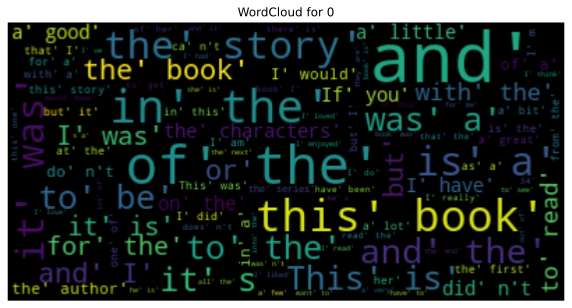

In [10]:
# Let's visuailze the ratings

word_cloud(list_tokenizer(rating_zero), 0)

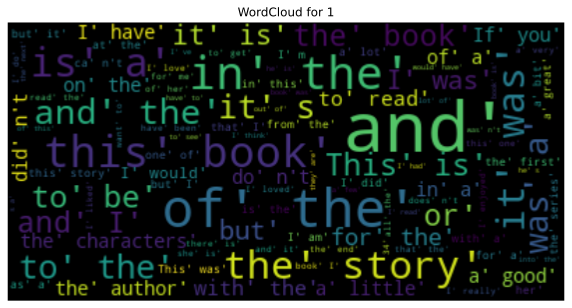

In [11]:
word_cloud(list_tokenizer(rating_zero), 1)

Now, we have suitable columns for model building, but before that we need to pre-process the text. Let's do that! 

### Pre-processing!
If you want a quick recap on pre-processing techniques you can check the notebook [**here**](https://github.com/RAravindDS/Learny/blob/main/NLP/TextCleaning/Cleaning_text_data.ipynb)

In [12]:
# 1. lowering case 
data['reviewText'] = data['reviewText'].str.lower()  # lowering the case! 
data.head()

,reviewText,rating
0,"jace rankin may be short, but he's nothing to ...",0
1,great short read. i didn't want to put it dow...,0
2,i'll start by saying this is the first of four...,0
3,aggie is angela lansbury who carries pocketboo...,0
4,i did not expect this type of book to be in li...,0


In [13]:
# 2. remove punctuation! 
data['reviewText'] = data['reviewText'].apply(lambda x: re.sub('[^a-z A-Z 0-9-]+', '', x))  # it removes the punctuation 
data.head()

,reviewText,rating
0,jace rankin may be short but hes nothing to me...,0
1,great short read i didnt want to put it down ...,0
2,ill start by saying this is the first of four ...,0
3,aggie is angela lansbury who carries pocketboo...,0
4,i did not expect this type of book to be in li...,0


In [14]:
# 3. remove stopwords! (you can check the notebook, if you have any doubt)

from spacy.lang.en.stop_words import STOP_WORDS
data['reviewText'] = data['reviewText'].apply(lambda x: " ".join([i for i in x.split() if i not in STOP_WORDS]) )

data.head()

,reviewText,rating
0,jace rankin short hes mess man hauled saloon u...,0
1,great short read didnt want read sitting sex s...,0
2,ill start saying books wasnt expecting 34concl...,0
3,aggie angela lansbury carries pocketbooks inst...,0
4,expect type book library pleased find price right,0


In [15]:
# 4. remove url and tags! 
data['reviewText'] = data['reviewText'].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , str(x)))
                                              
data.head()

,reviewText,rating
0,jace rankin short hes mess man hauled saloon u...,0
1,great short read didnt want read sitting sex s...,0
2,ill start saying books wasnt expecting 34concl...,0
3,aggie angela lansbury carries pocketbooks inst...,0
4,expect type book library pleased find price right,0


In [16]:
# 5. remove html tags! 
data['reviewText'] = data['reviewText'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())

data.head()

,reviewText,rating
0,jace rankin short hes mess man hauled saloon u...,0
1,great short read didnt want read sitting sex s...,0
2,ill start saying books wasnt expecting 34concl...,0
3,aggie angela lansbury carries pocketbooks inst...,0
4,expect type book library pleased find price right,0


In [17]:
# # 6. spelling correction 
# %time 
# data['reviewText'] = data['reviewText'].apply(lambda x: TextBlob(x).correct())

# data.head()

In [18]:
# 7. remove emails 
data['reviewText'] = data['reviewText'].apply(lambda x: re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', '', x))  # it will remove te emails 

In [19]:
# 8. remove extra spaces
data['reviewText'] = data['reviewText'].apply(lambda x: " ".join(x.split()))
data.head()

,reviewText,rating
0,jace rankin short hes mess man hauled saloon u...,0
1,great short read didnt want read sitting sex s...,0
2,ill start saying books wasnt expecting 34concl...,0
3,aggie angela lansbury carries pocketbooks inst...,0
4,expect type book library pleased find price right,0


In [20]:
# 9. lemmatizer 

%time
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

data["reviewText"] = data["reviewText"].apply(lambda text: lemmatize_words(text))
data.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


,reviewText,rating
0,jace rankin short he mess man hauled saloon un...,0
1,great short read didnt want read sitting sex s...,0
2,ill start saying book wasnt expecting 34conclu...,0
3,aggie angela lansbury carry pocketbook instead...,0
4,expect type book library pleased find price right,0


### Text to Words

Now, we have pre-processed the file, let's start the model buidling. 

But before model building, we need to convert the text to numbers. So, let's do this by two methods `BOW` & `TF-IDF`~


#### 1. Bag of Words 
If you have any doubt check our [**notebook**](https://github.com/RAravindDS/Learny/blob/main/NLP/BagofWords.ipynb)

But before this, let's split the data!

In [21]:
# data split 
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(data['reviewText'], data['rating'], test_size = 0.3)

In [22]:
# Convert text to numbers using (BOW)! 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# let's convert 
xtrain_bow = vectorizer.fit_transform(xtrain).toarray()
xtest_bow = vectorizer.transform(xtest).toarray()

#### 2. TF-IDF 

If you have any doubt you can check our [**notebook**](https://github.com/RAravindDS/Learny/blob/main/NLP/TFIDF/TFIDF.ipynb)

In [23]:
# Convert text to numbers using (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer  

tf_vectorizer = TfidfVectorizer()

# let's convert 
xtrain_tf = tf_vectorizer.fit_transform(xtrain).toarray()
xtest_tf = tf_vectorizer.transform(xtest).toarray()

### Model Building 

Here, we are going to use the `Gaussina NB` model. 

First we will see the results for `BOW` 

In [24]:
from sklearn.naive_bayes import GaussianNB

# USING BOW 
clf_bow = GaussianNB().fit(xtrain_bow, ytrain)  # fitting 
prediction_bow = clf_bow.predict(xtest_bow)  # predictions

# USINGN TFIDF 
clf_tf = GaussianNB().fit(xtrain_tf, ytrain)
prediction_tf = clf_tf.predict(xtest_tf)

In [25]:
# let's check our model! 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

def metrics(prediction, actual): 
    print('Confusion_matrix \n', confusion_matrix(actual, prediction))
    print('\nAccuracy:', accuracy_score(actual, prediction))
    print('\nclassification_report\n')
    print(classification_report(actual, prediction))
    
    
metrics(prediction_bow, ytest)

Confusion_matrix 
 [[1367 1043]
 [ 422  768]]

Accuracy: 0.5930555555555556

classification_report

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      2410
           1       0.42      0.65      0.51      1190

    accuracy                           0.59      3600
   macro avg       0.59      0.61      0.58      3600
weighted avg       0.65      0.59      0.61      3600



In [26]:
metrics(prediction_tf, ytest)

Confusion_matrix 
 [[1398 1012]
 [ 452  738]]

Accuracy: 0.5933333333333334

classification_report

              precision    recall  f1-score   support

           0       0.76      0.58      0.66      2410
           1       0.42      0.62      0.50      1190

    accuracy                           0.59      3600
   macro avg       0.59      0.60      0.58      3600
weighted avg       0.65      0.59      0.61      3600

